In [1]:
import matplotlib.pylab as plt
import numpy as np
import zlib
import glob
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from generator_class import DataGenerator
from tensorflow.keras.optimizers import SGD
import json
import argparse
import pandas as pd
#GPU/CPU Selection
gpu_setting = 'y'

from eval_utils import *

2024-01-09 22:06:53.403045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.style.use('/home/sophiaf/mystyle.mplstyle')

In [3]:

history_file = 'CNN/ResNet_v2_20240106_urllist012_debugtraining_history.json' # 'ResNet_v2_128training_history.json'

# history_file = 'CNN/ResNet_v2_20240104_urllist0training_history.json' # 'ResNet_v2_128training_history.json'
# Opening JSON file
f = open(history_file)
# returns JSON object as 
# a dictionary
hst = json.load(f)
f.close()

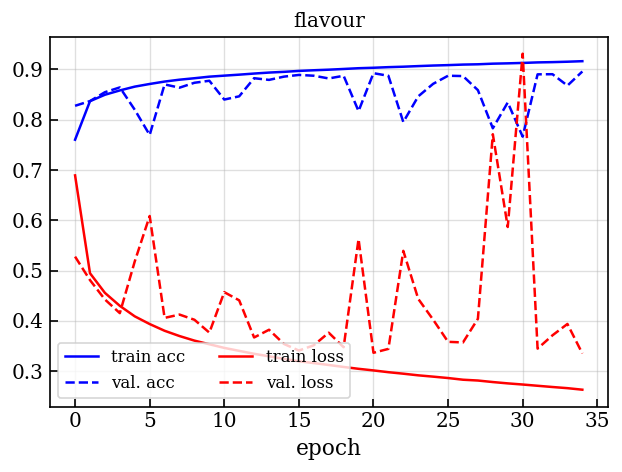

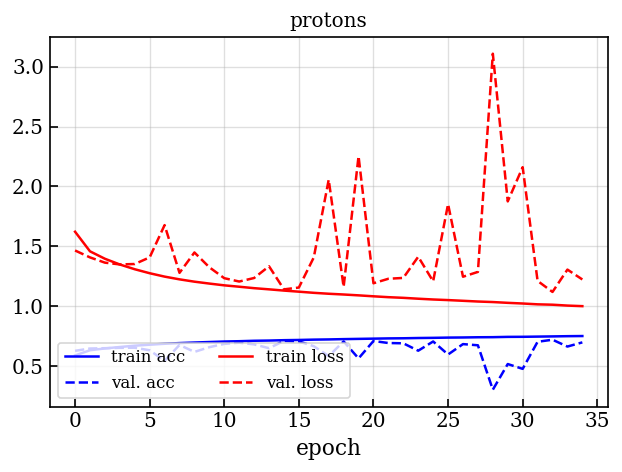

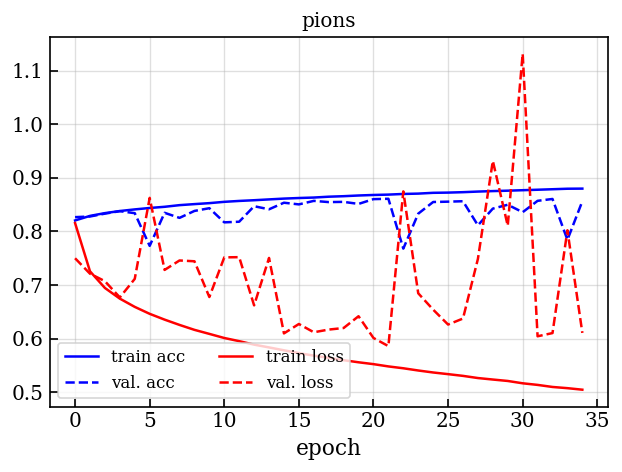

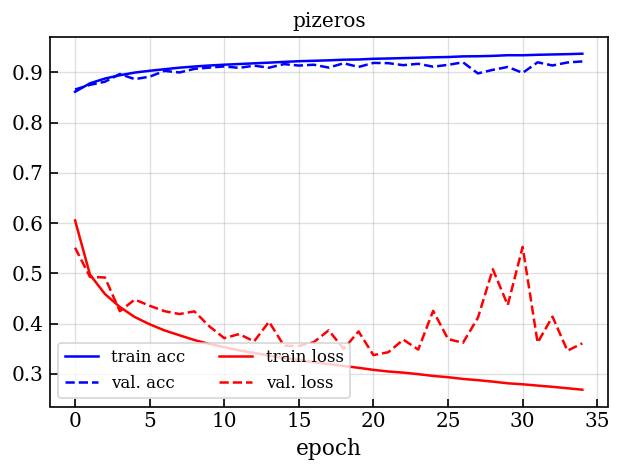

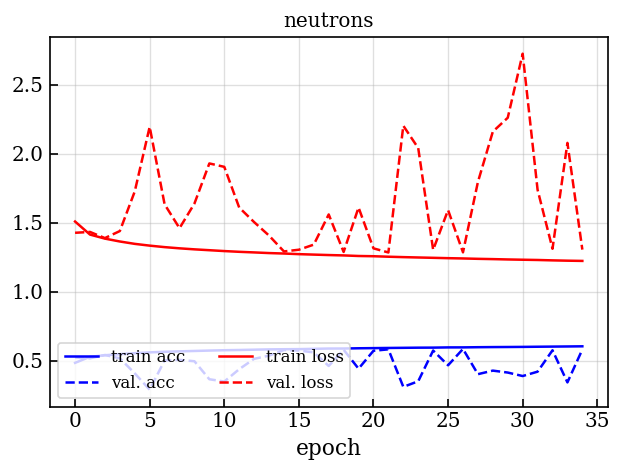

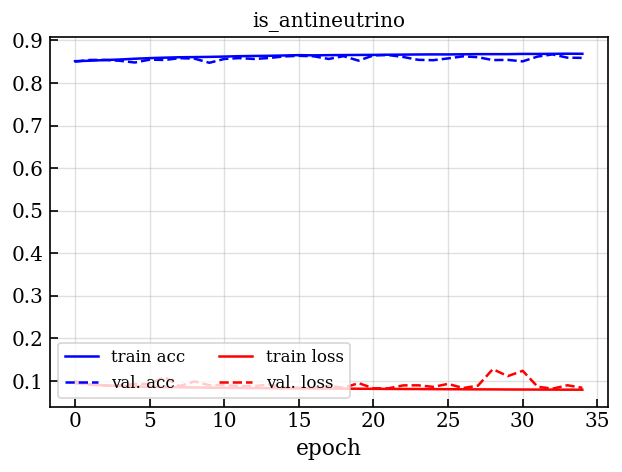

In [4]:
things_to_plot = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
for thing_to_plot in things_to_plot:
    plt.plot(hst['%s_accuracy'%(thing_to_plot)], c='b', ls='-', label='train acc')
    plt.plot(hst['val_%s_accuracy'%(thing_to_plot)], c='b', ls='--', label='val. acc')
    plt.plot(hst['%s_loss'%(thing_to_plot)], c='r', ls='-', label='train loss')
    plt.plot(hst['val_%s_loss'%(thing_to_plot)], c='r', ls='--', label='val. loss')
    # plt.ylim(0.25,.9)
    plt.legend(loc='lower left', ncol=2)
    plt.xlabel('epoch')
    plt.grid()
    plt.title(thing_to_plot)
    # plt.savefig('model_eval_plots/history_%s_20231223.pdf'%(thing_to_plot))
    plt.show()

## Evaluating test sample

In [5]:
model_name = 'ResNet_20240106_urllist0_1_2'
os.makedirs('model_eval_plots/%s'%(model_name), exist_ok=True)
tests = pd.read_pickle('CNN/%s_predictions.pkl'%(model_name))

In [6]:
test_data = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_df_testset.pkl')

In [7]:
test_data.shape

(61898, 15)

In [69]:
cls_tasks = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
output_options = [3,4,4,4,4,2]
colors = [ 'green','crimson', 'navy', 'mediumorchid',]

In [70]:
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 
true_meta = test_data.iloc[:len(pred[0])]

In [71]:
labels_flavour = ['NC', '$\\nu_e$ CC', '$\\nu_{\\mu}$ CC']
labels_n_particles = ['N=0', 'N=1', 'N=2', 'N=3+']
labels_is_anti = ['$\\nu$', '$\\bar{\\nu}$']

key_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_n_particles,
                 'pizeros': labels_n_particles,
                 'neutrons': labels_n_particles,
                 'is_antineutrino': labels_is_anti}

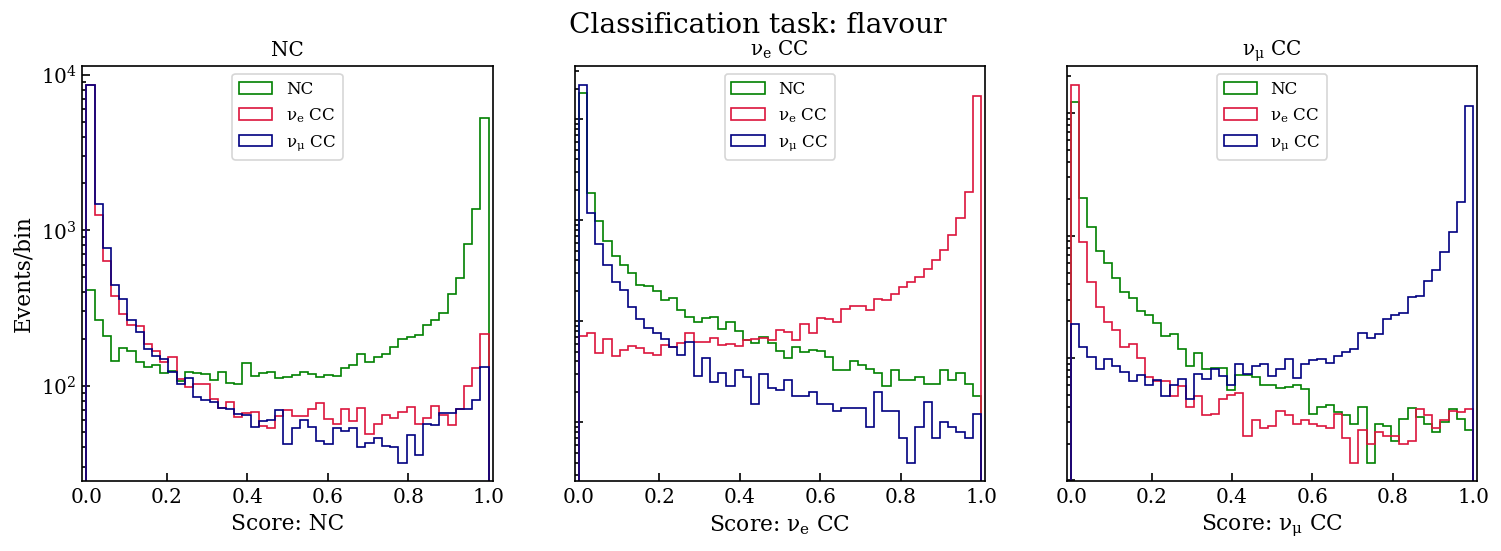

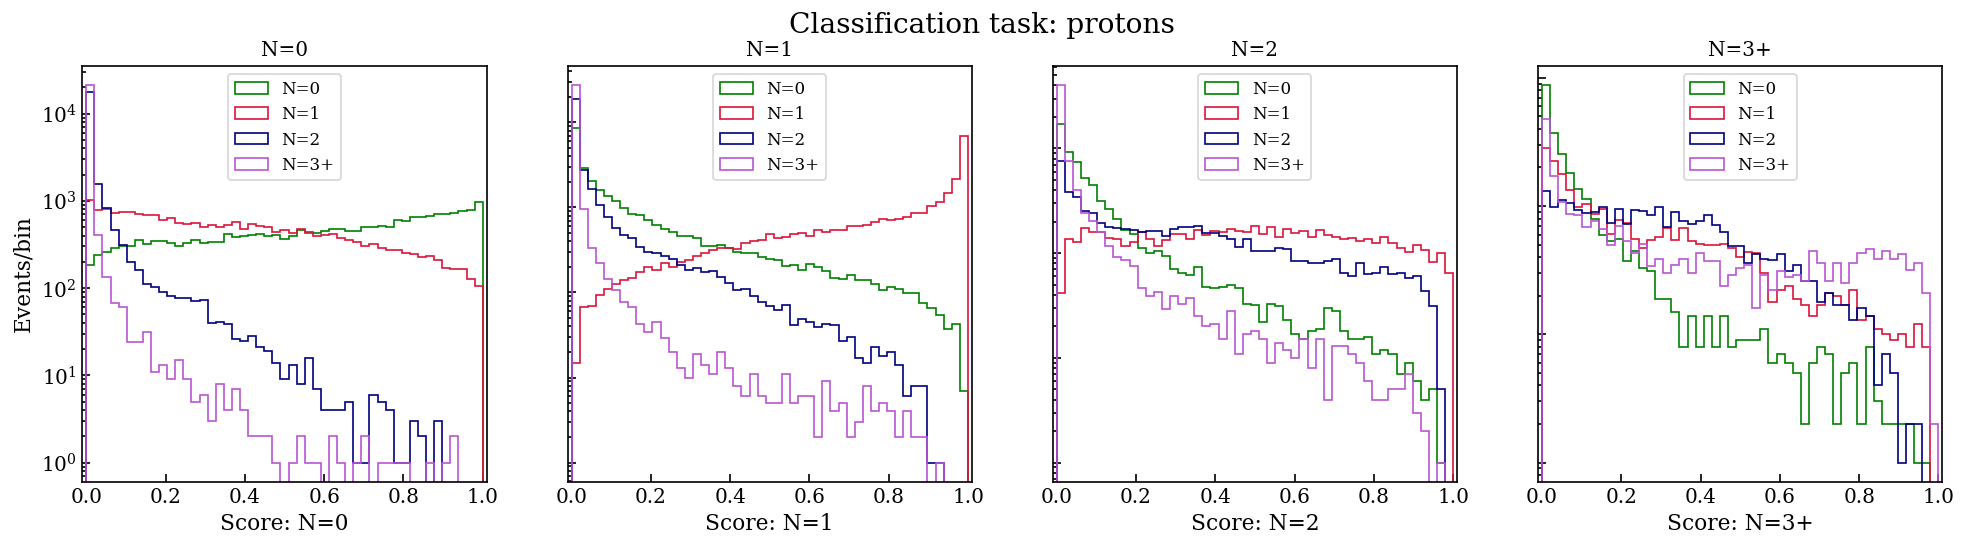

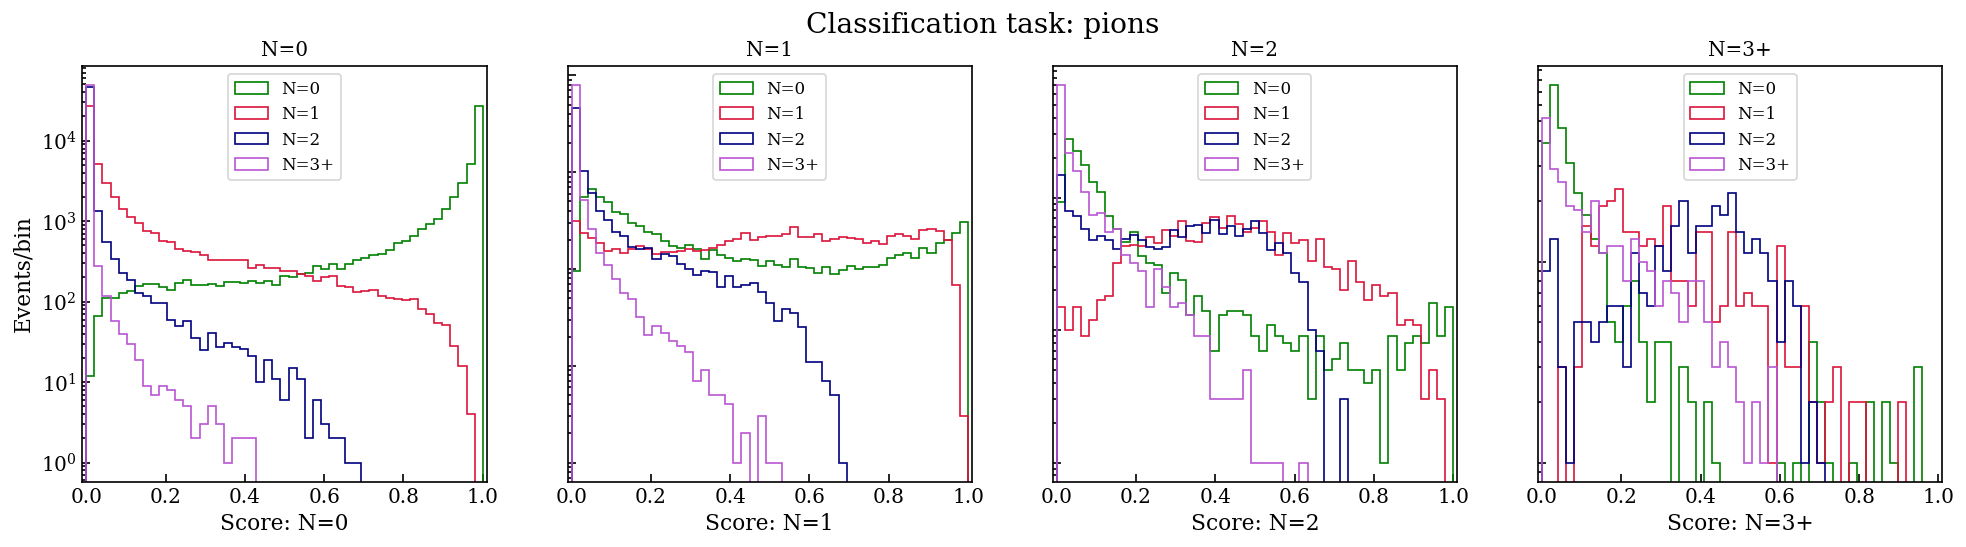

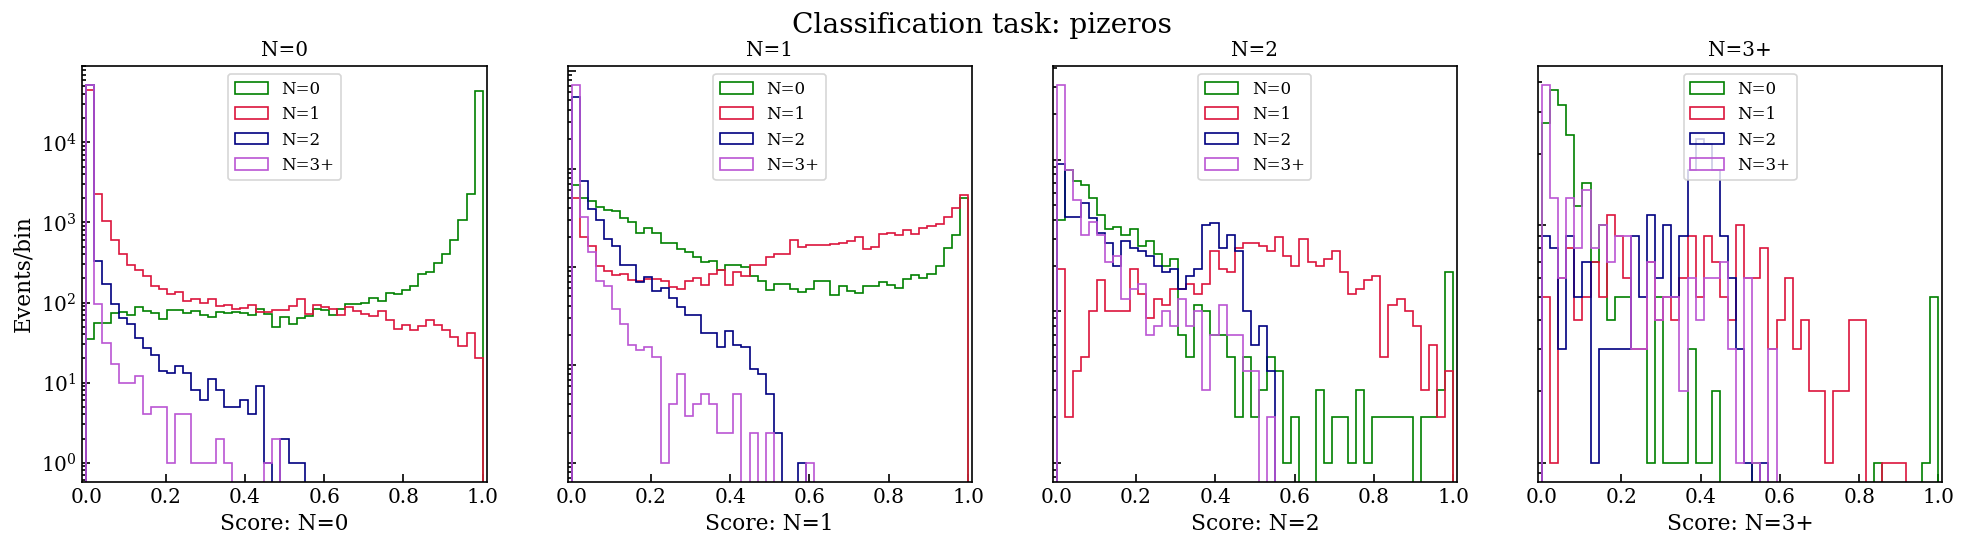

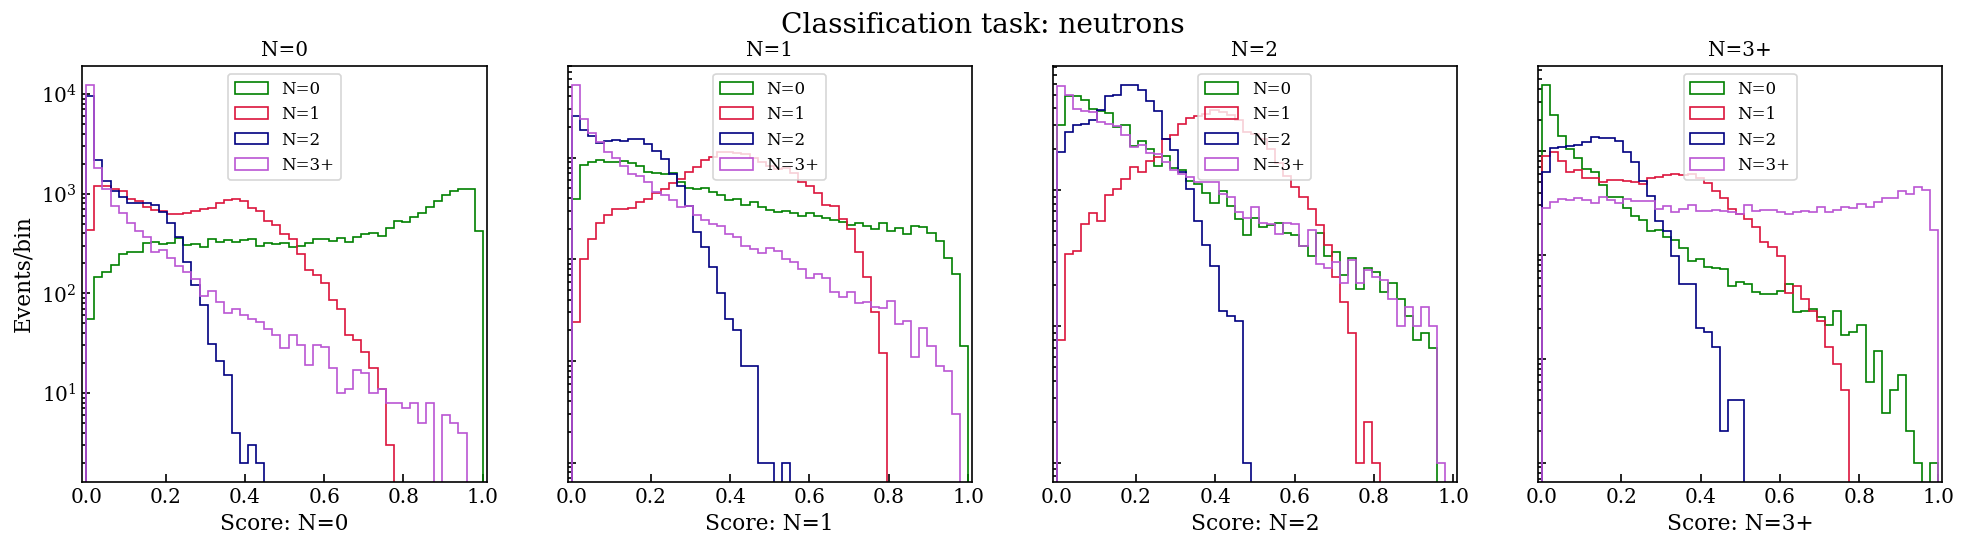

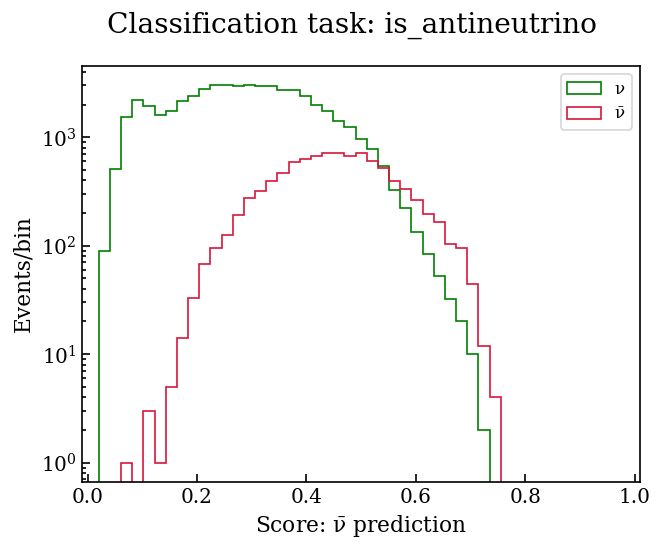

In [72]:
for cls_task in cls_tasks:
# cls_task = 'is_antineutrino' 
    num_in_pred = output_options[cls_tasks.index(cls_task)]
    class_options = np.arange(0, num_in_pred)
    cls_labels = key_labels[cls_task]
    
    if num_in_pred >2: 
        fig, axs = plt.subplots(1, len(class_options), figsize=(5*len(class_options),4.5))
        for cls, ax in zip(class_options, axs.flat):
            these_preds = pred[cls_tasks.index(cls_task)]
            for i in class_options:
                ax.hist(these_preds[true[cls_task]==cls][:,i], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[i], color=colors[i])
                
            ax.legend(loc='upper center')
            ax.set(xlabel='Score: %s'%(cls_labels[cls]), ylabel='Events/bin', 
                   title=cls_labels[cls], 
                   xlim=(-0.01, 1.01), 
                   yscale='log', 
                  )
        
        for ax in axs.flat:
            ax.label_outer()
        fig.suptitle('Classification task: %s'%(cls_task))
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show()
    
    else: 
        fig, ax = plt.subplots(1, figsize=(6,4.5))
        for cls in class_options:
            these_preds = pred[cls_tasks.index(cls_task)]
            
            ax.hist(these_preds[true[cls_task]==cls], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[cls], color=colors[cls])
        ax.legend(loc='upper right')
        ax.set(xlabel='Score: %s prediction'%(cls_labels[cls]), ylabel='Events/bin', 
               # title="Class, 
               xlim=(-0.01, 1.01), 
               yscale='log', 
              )
        fig.suptitle('Classification task: %s'%(cls_task))
        # plt.xlim(0,1)
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show() 

In [73]:
mask_1p_0pi = true['flavour']!=0 #not NC 
mask_1p_0pi &= true['protons']==1
mask_1p_0pi &= true['pions']==0
cc_1p_0pi = true[mask_1p_0pi]
print(sum(mask_1p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_1p_0pi["is_antineutrino"]==0)/len(cc_1p_0pi)))

19786
Fraction of nu/(nu+nubar): 0.91


In [47]:
mask_0p_0pi = true['flavour']!=0 #not NC 
mask_0p_0pi &= true['protons']==0
mask_0p_0pi &= true['pions']==0
cc_0p_0pi = true[mask_0p_0pi]
print(sum(mask_0p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_0p_0pi["is_antineutrino"]==0)/len(cc_0p_0pi)))

14005
Fraction of nu/(nu+nubar): 0.59


In [48]:
mask_2p_0pi = true['flavour']!=0 #not NC 
mask_2p_0pi &= true['protons']==2
mask_2p_0pi &= true['pions']==0
cc_2p_0pi = true[mask_2p_0pi]
print(sum(mask_2p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_2p_0pi["is_antineutrino"]==0)/len(cc_2p_0pi)))

3961
Fraction of nu/(nu+nubar): 0.94


### Decision boundary on NC/CC: 

We're interested in keeping the CC. It looks like we can keep CC flavor-agnostic in this case. 

In [49]:
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 

In [50]:
flav_preds = pred[0]
cc_score = np.sum(flav_preds[:,1:], axis=1)
nc_score = flav_preds[:,0]

In [51]:
from matplotlib.colors import LogNorm

In [52]:
mask_nc = true['flavour']==0
mask_cc = true['flavour']>0

In [53]:
xs = np.linspace(0,1,200)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)
all_true_cc = true[mask_cc]

for i, x in enumerate(xs): 
    nue_cc_pass = flav_preds[:,1]>x
    numu_cc_pass = flav_preds[:,2]>x
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    cc_true_pass = np.logical_and(cc_pass, true['flavour']>0)
    efficiency[i] = sum(cc_true_pass)/len(all_true_cc)
    purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

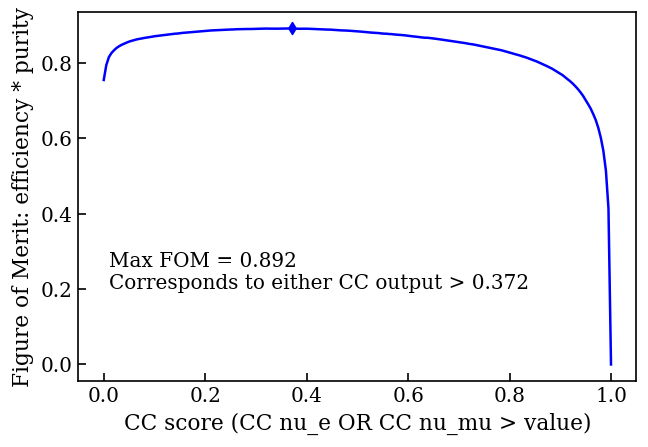

In [54]:
fom = efficiency*purity
plt.plot(xs, fom)
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('Figure of Merit: efficiency * purity')
plt.xlabel('CC score (CC nu_e OR CC nu_mu > value)')
plt.text(0.01, 0.2, 'Max FOM = %.3f \nCorresponds to either CC output > %.3f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
plt.show()


In [55]:
def cc_mask(preds, bound):
    nue_cc_pass = preds[:,1]>bound
    numu_cc_pass = preds[:,2]>bound
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    return cc_pass

/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


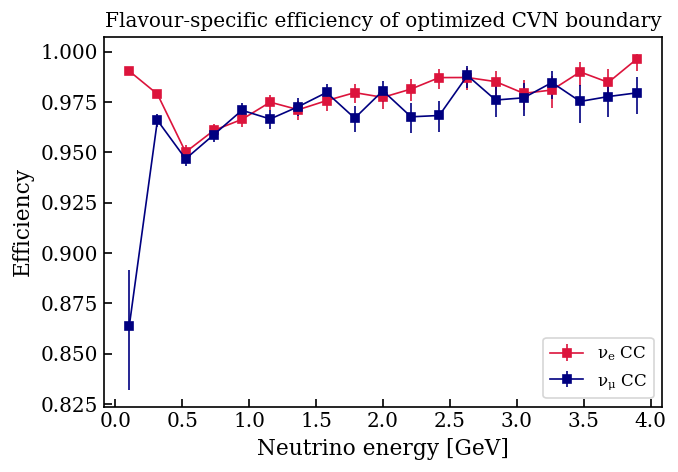

In [74]:
# efficiency as a function of energy 
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = cc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/n
        sigma_eff = compute_acceptance_uncertainty_bayesian(k,n)[0]
        sigma_effs[:,i] = np.abs(compute_acceptance_uncertainty_bayesian(k,n)[0]- effs[i])
        compute_acceptance_uncertainty_bayesian(k,n)[0]
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('Neutrino energy [GeV]')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.show()        

In [29]:
np.abs(compute_acceptance_uncertainty_bayesian(k,n)[0]- effs[i])

array([0.00560642, 0.00275358])

In [23]:
compute_acceptance_uncertainty_bayesian(k, n)

(array([0.98816, 0.99227]), array([0.00014017]))

In [ ]:
compute_acceptance_uncertainty_bayesian()

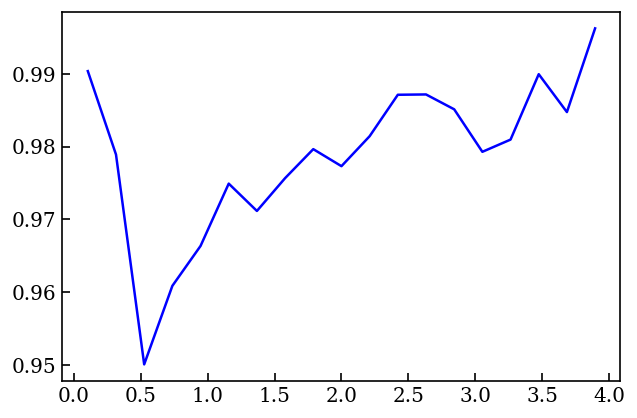

In [299]:
plt.plot(e_means, effs)
plt.show()

In [292]:
sum(pred_cc_in_e * true_cc_in_e)/sum(true_cc_in_e)

0.9882121807465619

In [278]:
max(true_meta['NuEnergy'])

3.99997

In [273]:
xs = np.linspace(0,1,200)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)
all_true_nc = true[mask_nc]

for i, x in enumerate(xs): 
    cc_pass = flav_preds[:,0]<x
    cc_true_pass = np.logical_and(cc_pass, true['flavour']>0)
    efficiency[i] = sum(cc_true_pass)/len(all_true_cc)
    purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

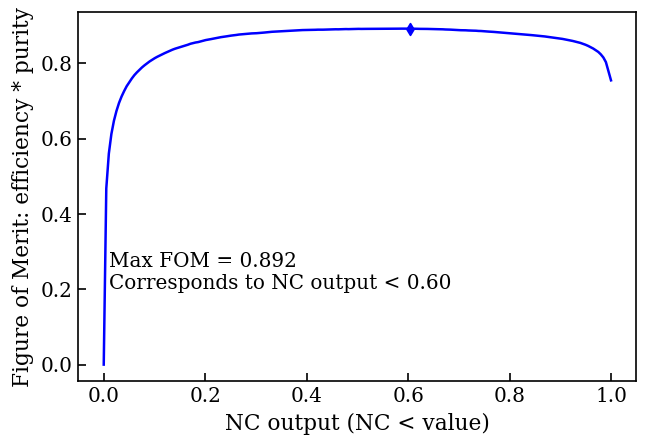

In [274]:
fom = efficiency*purity
plt.plot(xs, fom)
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('Figure of Merit: efficiency * purity')
plt.xlabel('NC output (NC < value)')
plt.text(0.01, 0.2, 'Max FOM = %.3f \nCorresponds to NC output < %.2f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
plt.show()


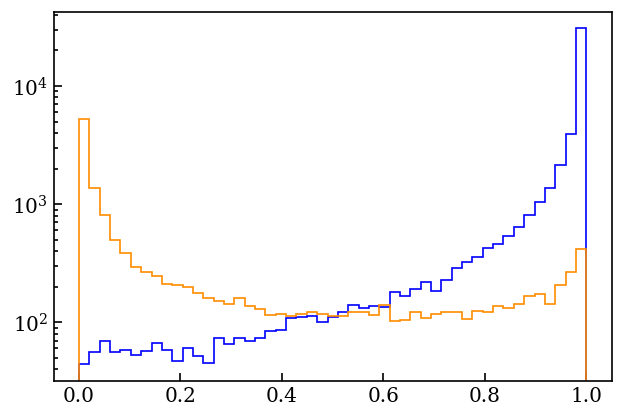

In [229]:
plt.hist(cc_score[mask_cc], bins=np.linspace(0,1,50), histtype='step')

plt.hist(cc_score[mask_nc], bins=np.linspace(0,1,50), histtype='step')
plt.yscale('log')
plt.show()

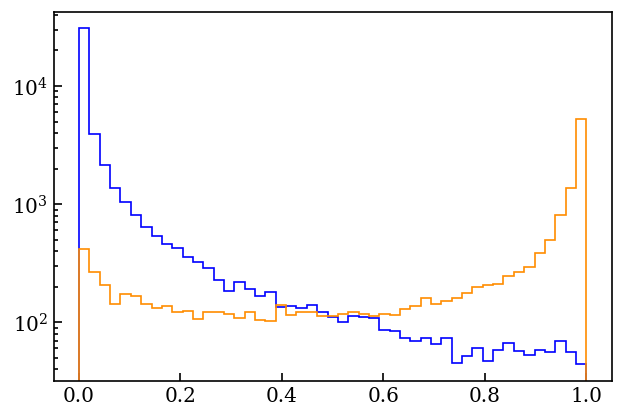

In [230]:
plt.hist(nc_score[mask_cc], bins=np.linspace(0,1,50), histtype='step')

plt.hist(nc_score[mask_nc], bins=np.linspace(0,1,50), histtype='step')
plt.yscale('log')
plt.show()

In [211]:
cc_score

array([0.2397719 , 0.30516756, 0.4963502 , ..., 0.00431397, 0.39820087,
       0.44070995], dtype=float32)

In [207]:
nc_score

array([0.52045614, 0.38966498, 0.00729968, ..., 0.991372  , 0.20359823,
       0.11858012], dtype=float32)

In [ ]:
weighted_cc_prediction = 

In [197]:
efficiency =  
purity = 1 
efficiency*purity #hi 


1